In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets

import pathlib
import matplotlib.pyplot as plt
import torch.nn.functional as F

# %matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from os import walk
for (dirpath, dirnames, filenames) in walk("./sars-covid-data"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)

Directory path:  ./sars-covid-data
Folder name:  ['COVID', 'non-COVID']
Directory path:  ./sars-covid-data\COVID
Folder name:  []
Directory path:  ./sars-covid-data\non-COVID
Folder name:  []


In [4]:
# transform
transformer = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Grayscale(),#make greyscale one channel
    transforms.ToTensor(), #0-1, numpy to tensor
    transforms.Normalize([0.5],
                        [0.5]) # 0-1 to -1,1 and normalized
])

In [5]:
train_path ='./sars-covid-data'
dataset = datasets.ImageFolder(train_path, transform=transformer)

In [8]:
len(dataset)

2481

In [35]:
len(train)

2000

In [15]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [6]:
train, test = torch.utils.data.random_split(dataset, [2000,481])

In [7]:
train_loader = DataLoader(train,batch_size =32, shuffle = True)

In [8]:
test_loader = DataLoader(test, batch_size =32, shuffle = True)

from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image

save images not show images (torchvision)
or matplot (instead of shoing images, just save it)

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


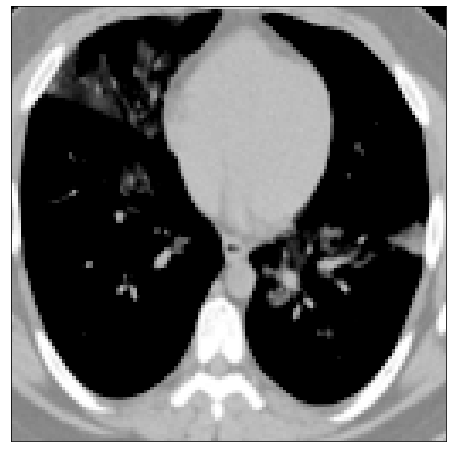

In [28]:
show_batch(train_images)

In [9]:
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

def show_img(img):
    img = img/2 + 0.5 #[-1,1] -> [0,1]
    plt.imshow(img.permute(1,2,0))
    # because the input of plt.imshow is (imagesize,imagesize,channels), the format of img is (channels,imagesize,imagesize)

In [15]:
classes = ['covid','non-covid']

In [14]:
train_img = train_images.numpy()
test_img = test_images.numpy()

In [61]:
train_images[0].shape

torch.Size([1, 128, 128])

In [62]:
train_labels.shape

torch.Size([32])

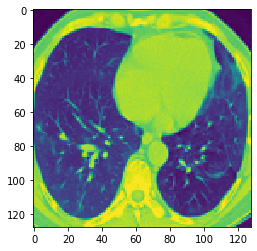

In [13]:
plt.imshow(train_images[0][0])

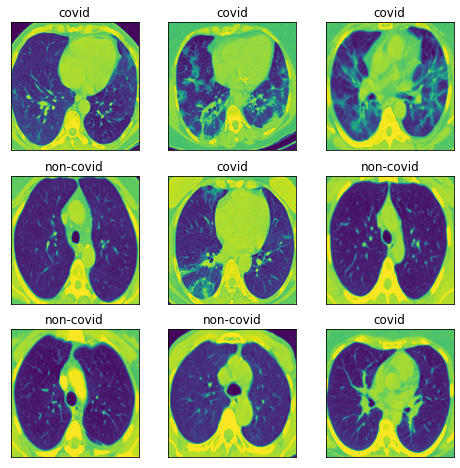

In [16]:
fig = plt.figure(figsize = (8,8))
for idx in np.arange(9):
    ax = fig.add_subplot(3,3,idx+1,xticks=[],yticks=[])
    plt.imshow(train_images[idx][0])
    ax.set_title(classes[train_labels[idx]])
    

for up and down, probably need to remove the linear layer (unet)
1. input = output
2. first want the middle part (very small)
3.from the small part see if covid or not

class CNNnet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size = 3, stride=1, padding = 1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.1),           
            nn.MaxPool2d(2,2), #(32*32*32)

            
            nn.Flatten(),
            nn.Linear(32768,128),#in features= , out features = 128
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    
    def forward(self, xb):
        return self.network(xb)

## transpose

In [30]:
class CnnAE(nn.Module):
    def __init__(self):
        super(CnnAE,self).__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, stride=1, padding = 1),
        #size 128
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            #nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1)
            
            #size 32
        )

        
        #decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding = 1),
            
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(in_channels=32,out_channels=16,
                           kernel_size=5,stride=2,output_padding=1,padding=2),
            
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 16, kernel_size = 3, stride=1, padding = 1),
        #size 128
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            #nn.ConvTranspose2d(in_channels=16, out_channels=16,
                           #kernel_size=5,stride=2,output_padding=1,padding=2),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=1,
                           kernel_size=5,stride=2,output_padding=1,padding=2),
            
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.1),
            #nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
           # nn.BatchNorm2d(16),
            #nn.LeakyReLU(0.1),
            #nn.Conv2d(16, 1, kernel_size = 3, stride = 1, padding = 1)
            
            
            #nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.encoder(x)
        x=self.decoder(x)
        return x

## max uppooling

In [63]:
class CnnAE(nn.Module):
    def __init__(self):
        super(CnnAE,self).__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, stride=1, padding = 1),
        #size 128
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2,2, return_indices=True),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            #nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2,2, return_indices=True),
            
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1)
            
            #size 32
        )

        
        #decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding = 1),
            
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            #nn.ConvTranspose2d(in_channels=32,out_channels=16,
                           #kernel_size=5,stride=2,output_padding=1,padding=2),
            nn.MaxUnpool2d(2),
            
            #nn.BatchNorm2d(16),
            #nn.LeakyReLU(0.1),
            nn.Conv2d(16, 16, kernel_size = 3, stride=1, padding = 1),
        #size 128
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            #nn.ConvTranspose2d(in_channels=16, out_channels=16,
                           #kernel_size=5,stride=2,output_padding=1,padding=2),
            
            #nn.ConvTranspose2d(in_channels=16, out_channels=1,
                           #kernel_size=5,stride=2,output_padding=1,padding=2),
            
            nn.MaxUnpool2d(2),
            #nn.BatchNorm2d(1),
            #nn.LeakyReLU(0.1),
            #nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
           # nn.BatchNorm2d(16),
            #nn.LeakyReLU(0.1),
            nn.Conv2d(16, 1, kernel_size = 3, stride = 1, padding = 1)
            
            
            #nn.Sigmoid()
        )
        
    def forward(self,x):
        #encoded, indices = self.encoder(x)
        x = self.encoder(x)
        x=self.decoder(x)
        return x

## interpolation

In [56]:
from torch.nn.functional import interpolate

In [66]:
class CnnAE(nn.Module):
    def __init__(self):
        super(CnnAE,self).__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, stride=1, padding = 1),
        #size 128
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            #nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1)
            
            #size 32
        )

        
        #decoder
        self.decoder1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding = 1),
            
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1)
        )
        
        self.decoder2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size = 3, stride=1, padding = 1),
            
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1)
        )
        
        self.decoder3 = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size = 3, stride=1, padding = 1),
            
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.1)
        )
            
        
    def forward(self,x):
        x = self.encoder(x)
        #x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.decoder1(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest', align_corners=True)
        x = self.decoder2(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest', align_corners=True)
        x = self.decoder3(x)

        return x

In [74]:
#try
x = torch.randn(2,1,128,128)
cnn1=nn.Conv2d(1, 16, kernel_size = 3, stride=1, padding = 1)
cnn2=nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1)
pool=nn.MaxPool2d(2,2)
convt1 = nn.ConvTranspose2d(in_channels=32,
                           out_channels=16,
                           kernel_size=3,stride=2,output_padding=1,padding=1)
convt2 = nn.ConvTranspose2d(in_channels=16,
                           out_channels=1,
                           kernel_size=3,stride=2,output_padding=1,padding=1)
y=cnn1(x)
y=pool(y)
y=cnn2(y)
y=pool(y)
y=convt1(y)
y=convt2(y)
y.shape

torch.Size([2, 1, 128, 128])

In [67]:
model = CnnAE().to(device)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = Adam(model.parameters(), lr=1e-3)
# mean-squared error loss
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [75]:
print(model)

CnnAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (2): Sigmoid()
  )
)


In [77]:
for i, (images,labels) in enumerate (train_loader):
    print(type(images))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


KeyboardInterrupt: 

In [21]:
train_images.shape

torch.Size([32, 1, 128, 128])

In [28]:
def train(epoch):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    total_step = len(train_loader)


    for i, (images,labels) in enumerate (train_loader):
        #images = torch.squeeze(images)
        if torch.cuda.is_available():
            #images = Variable(images.cuda())            
            images = images.to(device)
            #labels = Variable(labels.cuda())
            
        optimizer.zero_grad() 
    
        outputs = model(images) #give us prediction
        #print(outputs.shape)
        #outputs = torch.argmax(outputs, dim=1)
        loss = criterion(outputs,images)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data*images.size(0)
        
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        #_,predicted = torch.max(outputs.data,1)
        
        #train_accuracy += int(torch.sum(prediction == labels.data))
    
   # train_accuracy = train_accuracy / len(train)
   # train_loss = train_loss / len(train)
    
 


    

In [ ]:
def test(epoch):
    model.test()
    test_accuracy = 0.0
    for i, (images,labels) in enumerate (test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        outputs = model(images)
        _,predicted = torch.max(outputs.data,1)
        

In [68]:
#best_acc = 0.0
num_epochs = 1
train_loss = 0
for epoch in range(num_epochs):
    train(epoch)
    
    

ValueError: align_corners option can only be set with the interpolating modes: linear | bilinear | bicubic | trilinear

In [33]:
output = model(train_images)

In [43]:
output[0][0].size

16384

In [44]:
128*128

16384

Reconstructed Images


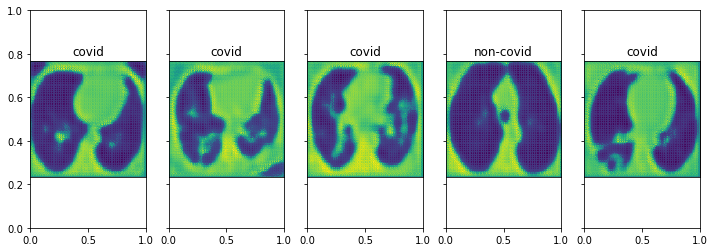

In [42]:
#Reconstructed Images

output = model(train_images)
output = output.detach().numpy()
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(output[idx][0])
    ax.set_title(classes[train_labels[idx]])
plt.show() 

In [47]:
fig.savefig('transposeCnnAE.png')